In [1]:
import random

import matplotlib as mpl
import numpy as np
import torch
import torch.utils.data
import torch.nn.functional as F

import theseus as th
import theseus.utils.examples as theg

%load_ext autoreload
%autoreload 2

torch.set_default_dtype(torch.double)

device = "cuda:0" if torch.cuda.is_available else "cpu"
seed = 0
torch.random.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["font.size"] = 16

In [8]:
path = !pwd
path = path[0][:-5]

In [9]:
dataset_dir =  path + "/data/motion-planning-2d/dataset"
train_dataset = theg.TrajectoryDataset(True, 1000, dataset_dir, val_ratio=0.2, map_type="tarpit", filter_collision_maps=True)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

test_dataset = theg.TrajectoryDataset(False, 1000, dataset_dir, val_ratio=0.2, map_type="tarpit", filter_collision_maps=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

print(len(train_dl))

batch = next(iter(train_dl))
print(batch.keys())
for k, v in batch.items():
    if k != "file_id":
        print(f"{k:20s}: {v.shape}")
    else:
        print(f"{k:20s}: {v}")

23
dict_keys(['map_tensor', 'sdf_origin', 'cell_size', 'sdf_data', 'expert_trajectory', 'file_id'])
map_tensor          : torch.Size([32, 128, 128])
sdf_origin          : torch.Size([32, 2])
cell_size           : torch.Size([32, 1])
sdf_data            : torch.Size([32, 128, 128])
expert_trajectory   : torch.Size([32, 4, 101])
file_id             : ['tarpit_15', 'tarpit_682', 'tarpit_244', 'tarpit_598', 'tarpit_317', 'tarpit_970', 'tarpit_940', 'tarpit_303', 'tarpit_683', 'tarpit_117', 'tarpit_150', 'tarpit_242', 'tarpit_664', 'tarpit_985', 'tarpit_696', 'tarpit_971', 'tarpit_710', 'tarpit_648', 'tarpit_181', 'tarpit_719', 'tarpit_190', 'tarpit_288', 'tarpit_668', 'tarpit_105', 'tarpit_941', 'tarpit_75', 'tarpit_201', 'tarpit_95', 'tarpit_229', 'tarpit_35', 'tarpit_55', 'tarpit_631']


In [10]:
trajectory_len = 101
num_time_steps = trajectory_len - 1
map_size = 128
safety_distance = 0.4
robot_radius = 0.4
total_time = 10.0
dt_val = total_time / num_time_steps
Qc_inv = [[1.0, 0.0], [0.0, 1.0]]
collision_w = 20.0
boundary_w = 100.0

In [11]:
planner = theg.MotionPlanner(
    optim_method="levenberg_marquardt",
    max_optim_iters=2,
    step_size=0.3,
    map_size=map_size,
    epsilon_dist=safety_distance + robot_radius,
    total_time=total_time,
    collision_weight=collision_w,
    Qc_inv=Qc_inv,
    num_time_steps=num_time_steps,
    device=device,
)

In [81]:
from model import CNN, prepare_training_data, loss_func

In [82]:
def get_straight_line_inputs(start, goal):
    # Returns a dictionary with pose and velocity variable names associated to a 
    # straight line trajectory between start and goal
    start_goal_dist = goal - start
    avg_vel = start_goal_dist / total_time
    unit_trajectory_len = start_goal_dist / (trajectory_len - 1)
    input_dict = {}
    for i in range(trajectory_len):
        input_dict[f"pose_{i}"] = (start + unit_trajectory_len * i).to(device)
        if i == 0 or i == trajectory_len - 1:
            input_dict[f"vel_{i}"] = torch.zeros_like(avg_vel).to(device)
        else:
            input_dict[f"vel_{i}"] = avg_vel.to(device)
    return input_dict

In [84]:
batch = next(iter(train_dl))
with torch.no_grad():
    map_tensor, start_and_goal, label_traj = \
            prepare_training_data(batch, batchsize=32, include_sdf=False)
    output = CNN_model(map_tensor, start_and_goal)

    initial_traj_dict = get_traj_dict_from_tensor_path(output, start_and_goal)
    print(initial_traj_dict["pose_0"].size(), initial_traj_dict["pose_0"].requires_grad)

torch.Size([32, 2]) False


In [85]:
from IPython.display import clear_output

In [151]:
initial_trajectory_dicts = []
best_loss = float("inf")
losses = []
num_epochs = 30
best_epoch = None

CNN_model = CNN()
CNN_model.to(device)
model_optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(model_optimizer, step_size=10, gamma=0.2)

# For speed considerations, we set the max number of optimizer iterations to a low number (2).
# This will also encourage the initial trajectory model to produce trajectories of higher quality.
planner.layer.optimizer.set_params(max_iterations=2)
CNN_model.train()
for epoch in range(num_epochs):
    for batch in train_dl:
        CNN_model.zero_grad()
        map_tensor, start, goal, label_traj = \
            prepare_training_data(batch, batchsize=32, include_sdf=False)
        
        
        # Step 1: Generate an initial trajectory by querying the model on the set of maps.
        output = CNN_model(map_tensor, start, goal)
        initial_traj_dict = get_traj_dict_from_tensor_path(output, start, goal)
        
        # This updates the motion planner's input dictionary with the trajectories produced above.
        start = batch["expert_trajectory"][:, :2, 0].to(device)
        goal = batch["expert_trajectory"][:, :2, -1].to(device)
        planner_inputs = {
            "sdf_origin": batch["sdf_origin"].to(device),
            "start": start.to(device),
            "goal": goal.to(device),
            "cell_size": batch["cell_size"].to(device),
            "sdf_data": batch["sdf_data"].to(device),
        }
        
        planner_inputs.update(initial_traj_dict)
        
        
        # Step 2: Optimize to improve on the initial trajectories produced by the model.
        planner.layer.forward(
            planner_inputs,
            optimizer_kwargs={
                "verbose": False,
                "damping": 0.1,
            }
        )

        initial_trajectory_dicts.append(
            dict([(k, v.detach().clone()) for k, v in initial_traj_dict.items()]))

        # Step 3: Compute a loss evaluating the quality of the trajectories.
        # The loss consists of two terms. The first one encourages the final trajectory to 
        # match an expert trajectory available for this map (imitation_loss).
        # The second term uses the trajectory planner's total squared error, which also
        # encourages the trajectory to be smooth and avoid obstacles. We scale this term
        # by a small factor, since otherwise it would completely dominate over the
        # imitation loss.
        
        error_loss = planner.objective.error_squared_norm().mean() / planner.objective.dim()
        solution_trajectory = planner.get_trajectory()
        imitation_loss = F.mse_loss( \
            batch["expert_trajectory"].to(device), solution_trajectory)
        imitation_loss = loss_func(output, label_traj)
        loss = imitation_loss + 0.01 * error_loss
        
        # Step 4: Do backpropagation through the TheseusLayer and update the model parameters.
        loss.backward()
        model_optimizer.step()
    
    scheduler.step()
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
    losses.append(loss.item())
    clear_output(wait=True)
    print("------------------------------------")
    print(f"             Epoch {epoch}")
    print("------------------------------------")
    print(f"{'Imitation loss':20s}: {imitation_loss.item():.3f}")
    print(f"{'Error loss':20s}: {error_loss.item():.3f}")
    print(f"{'Total loss':20s}: {loss.item():.3f}")
    print("------------------------------------")
    print("------------------------------------")

------------------------------------
             Epoch 29
------------------------------------
Imitation loss      : 2.348
Error loss          : 50.414
Total loss          : 2.853
------------------------------------
------------------------------------


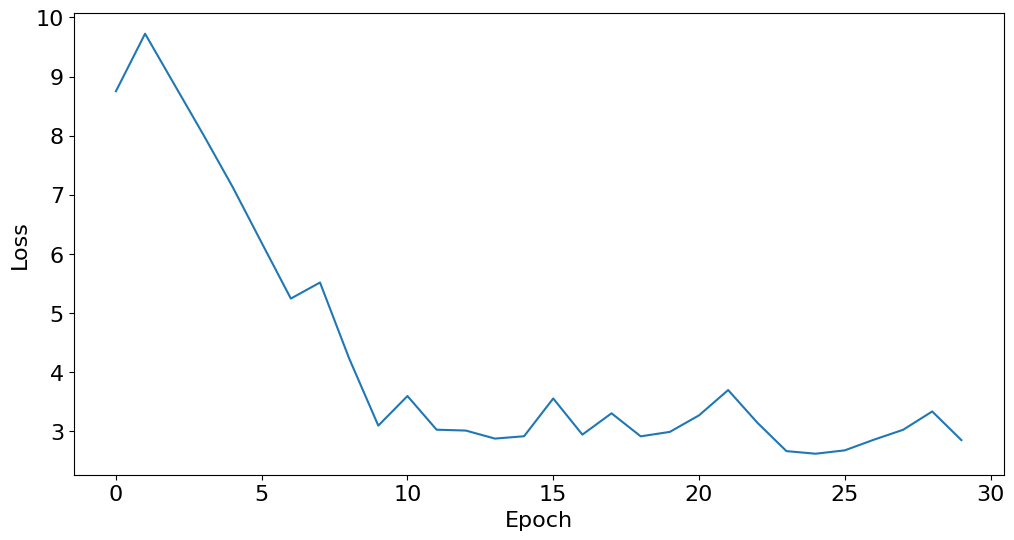

In [152]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [133]:
def get_trajectory(values_dict):
    trajectory = torch.empty(values_dict[f"pose_0"].shape[0], 4, trajectory_len, device=device)
    for i in range(trajectory_len):
        trajectory[:, :2, i] = values_dict[f"pose_{i}"]
        trajectory[:, 2:, i] = values_dict[f"vel_{i}"]
    return trajectory

def plot_trajectories(initial_traj_dict, solution_traj_dict, include_expert=False):
    initial_traj = get_trajectory(initial_traj_dict).cpu()
    sol_traj = get_trajectory(solution_traj_dict).detach().clone().cpu()

    sdf = th.eb.SignedDistanceField2D(
        th.Point2(batch["sdf_origin"]),
        th.Variable(batch["cell_size"]),
        th.Variable(batch["sdf_data"]),
    )
    trajectories = [initial_traj, sol_traj]
    if include_expert:
        trajectories.append(batch["expert_trajectory"])
    figs = theg.generate_trajectory_figs(
        batch["map_tensor"], 
        sdf, 
        trajectories,
        robot_radius=0.4, 
        labels=["initial trajectory", "solution trajectory", "expert"], 
        fig_idx_robot=1,
        figsize=(4, 4)
    )
    for fig in figs:
        fig.show()

/tmp/ipykernel_270/613842182.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


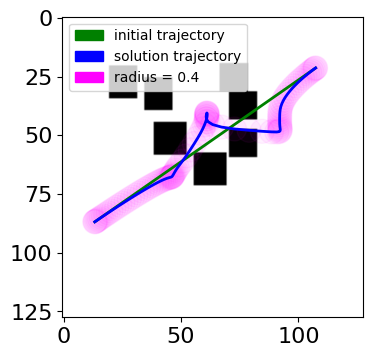

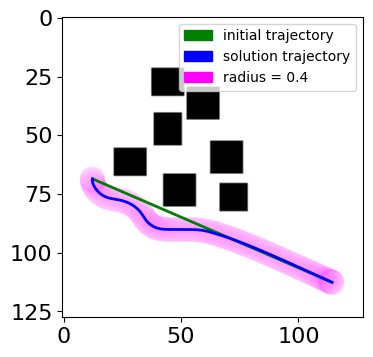

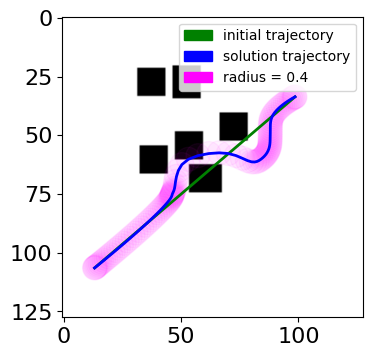

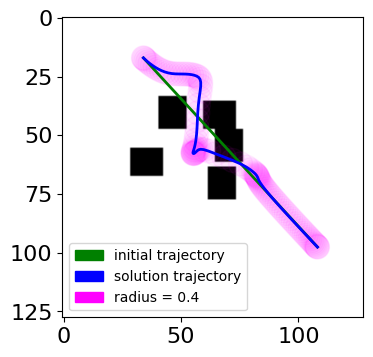

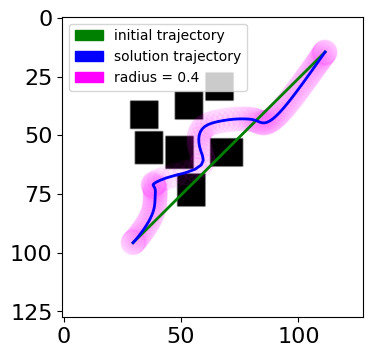

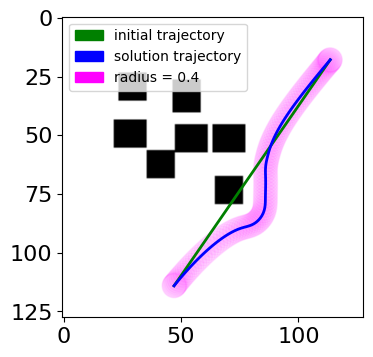

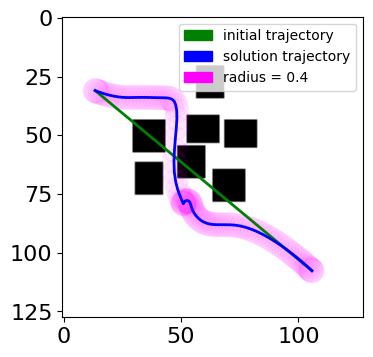

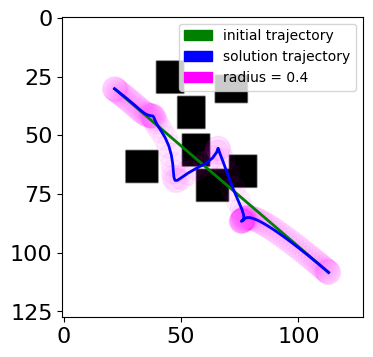

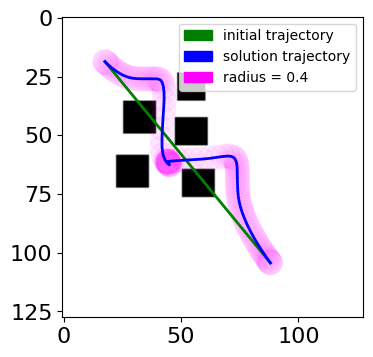

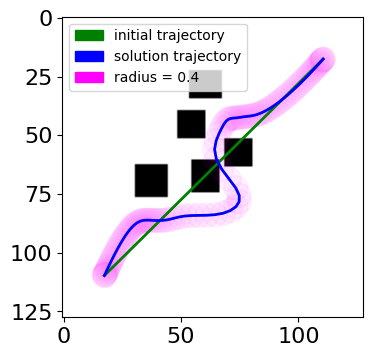

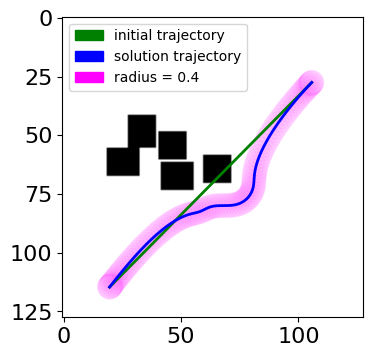

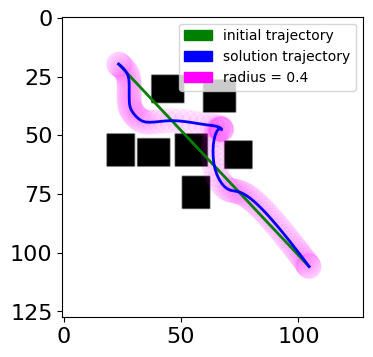

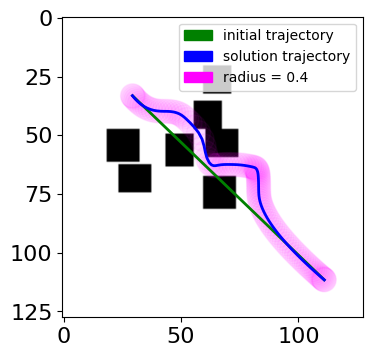

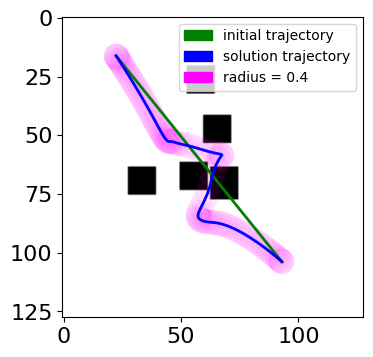

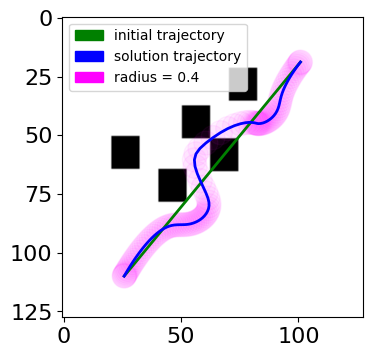

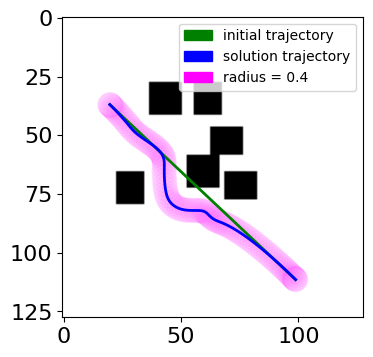

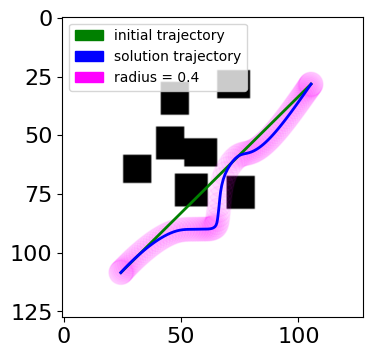

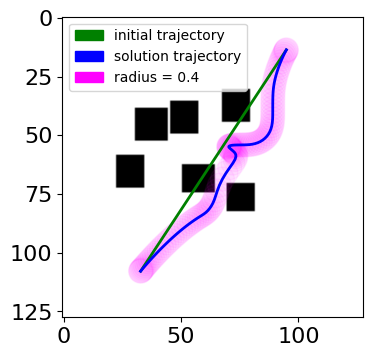

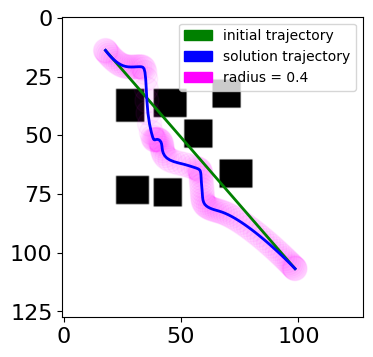

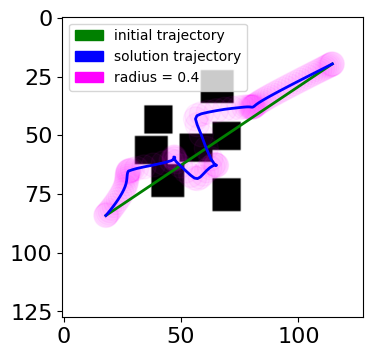

In [150]:
straight_traj_dict = planner.get_variable_values_from_straight_line(
    planner_inputs["start"], planner_inputs["goal"])

planner_inputs.update(straight_traj_dict)
planner.layer.optimizer.set_params(max_iterations=10)
solution_dict, info = planner.layer.forward(
    planner_inputs,
    optimizer_kwargs={
        "verbose": False,
        "damping": 0.1,
    }
)
plot_trajectories(straight_traj_dict, solution_dict)

In [134]:
batch = next(iter(test_dl))
start = batch["expert_trajectory"][:, :2, 0]
goal = batch["expert_trajectory"][:, :2, -1]

print(start.size(), goal.size())
print(start[0], goal[0])
print(start[1], goal[1])
print(start[2], goal[2])

torch.Size([32, 2]) torch.Size([32, 2])
tensor([-3.0095, -2.6719]) tensor([2.9644, 3.5364])
tensor([ 2.6469, -3.0038]) tensor([-3.0256,  3.4731])
tensor([-3.6910,  0.6060]) tensor([ 3.7689, -3.6147])


In [143]:
def get_traj_dict_from_tensor_path(output_path, start, goal):
    # Returns a dictionary with pose and velocity variable names associated to a 
    # trajectory between start and goal outputted by the CNN model
    # output_path has size [32,1,198], start and goal both have size [32,2]
    # note: pose_1 = (x_1, x_100)
    
    step_time = 0.1 # given by total time = 10.0 divided by 100 timesteps
    output_path = torch.squeeze(output_path, 1)
    input_dict = {}
    input_dict["pose_0"] = start.to(device)
    input_dict["vel_0"] = torch.zeros(32, 2).to(device)
    input_dict["pose_100"] = goal.to(device)
    input_dict["vel_100"] = torch.zeros(32, 2).to(device)
    
    for i in range(1, 100):
        input_dict[f"pose_{i}"] = torch.concat((output_path[:,i-1:i], output_path[:, i+98:i+99]), 1).to(device)
        # input_dict[f"vel_{i}"] = ((input_dict[f"pose_{i}"] - input_dict[f"pose_{i-1}"])/step_time).to(device)
        input_dict[f"vel_{i}"] = torch.zeros(32, 2).to(device)
        
    return input_dict

In [136]:
with torch.no_grad():
    map_tensor, start, goal, label_traj = \
            prepare_training_data(batch, batchsize=32, include_sdf=False)
    output = CNN_model(map_tensor, start, goal)

initial_traj_dict = get_traj_dict_from_tensor_path(output, start, goal)

initial_traj = output.reshape(32, 2, 99).detach().to("cpu")
print(initial_traj[0:1, :, :3])

print(initial_traj_dict["pose_1"][0])
print(initial_traj_dict["pose_2"][0])
print(initial_traj_dict["pose_3"][0])




torch.Size([32, 198])
tensor([[[-3.9464, -3.8789, -4.1872],
         [-5.0736, -5.3176, -4.9964]]])
tensor([-3.9464, -5.0736], device='cuda:0')
tensor([-3.8789, -5.3176], device='cuda:0')
tensor([-4.1872, -4.9964], device='cuda:0')


/tmp/ipykernel_270/553149259.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[0].show()


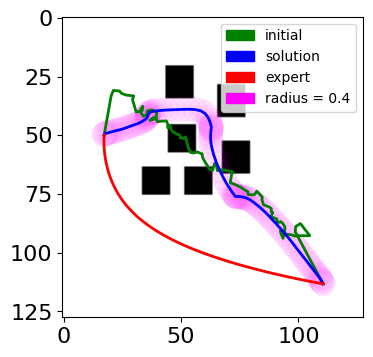

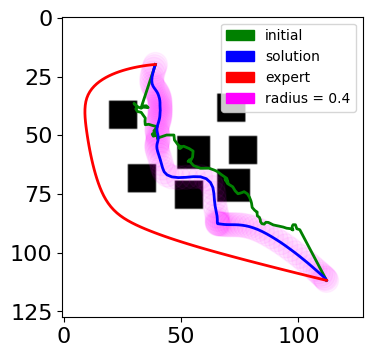

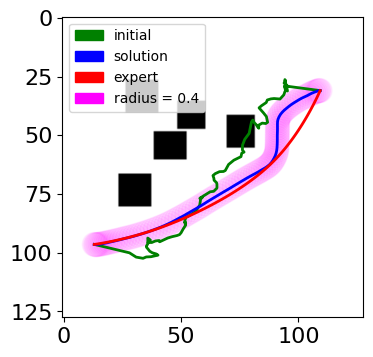

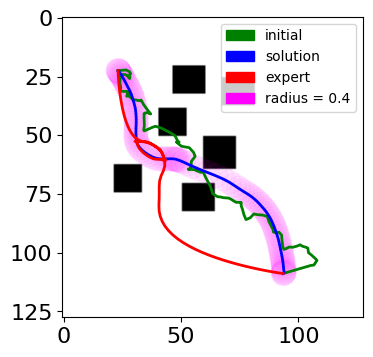

In [ ]:
batch = next(iter(test_dl))
with torch.no_grad():
    map_tensor, start, goal, label_traj = \
            prepare_training_data(batch, batchsize=32, include_sdf=False)
    output = CNN_model(map_tensor, start, goal)

initial_traj_dict = get_traj_dict_from_tensor_path(output, start, goal)


planner_inputs = {
    "sdf_origin": batch["sdf_origin"].to(device),
    "start": start.to(device),
    "goal": goal.to(device),
    "cell_size": batch["cell_size"].to(device),
    "sdf_data": batch["sdf_data"].to(device),
}
planner_inputs.update(initial_traj_dict)
planner.layer.optimizer.set_params(max_iterations=10)

solution_dict, info = planner.layer.forward(
    planner_inputs,
    optimizer_kwargs={
        "verbose": False,
        "damping": 0.1,
    }
)

initial_traj = get_trajectory(initial_traj_dict).detach().clone().cpu()
sol_traj = get_trajectory(solution_dict).detach().clone().cpu()


num_examples = 10
sdf = th.eb.SignedDistanceField2D(
    th.Point2(batch["sdf_origin"]),
    th.Variable(batch["cell_size"]),
    th.Variable(batch["sdf_data"]),
)

for i in range(num_examples):
    sdf = th.eb.SignedDistanceField2D(
        th.Point2(batch["sdf_origin"][i].unsqueeze(0)),
        th.Variable(batch["cell_size"][i].unsqueeze(0)),
        th.Variable(batch["sdf_data"][i].unsqueeze(0)),
    )

    figs = theg.generate_trajectory_figs(
        batch["map_tensor"][i].unsqueeze(0), 
        sdf, 
        [initial_traj[i].unsqueeze(0), sol_traj[i].unsqueeze(0), batch["expert_trajectory"][i].unsqueeze(0)],
        robot_radius=0.4, 
        labels=["initial", "solution" , "expert"], 
        fig_idx_robot=1,
        figsize=(4, 4),
    )

    figs[0].show()




In [22]:
torch.cuda.empty_cache()